In [1]:
!nvidia-smi

Mon Apr 13 16:30:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P6000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   36C    P0    66W / 250W |      1MiB / 24449MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import numpy as np
import math
import os
from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import statsmodels.api as sm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [3]:
print(torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0))

True 1 Quadro P6000


In [4]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# model path
model_path = "/storage/"

# model name
model_name_pt = "pytorch_nima_ps_v2_netg20200324-202041"

# config device
device = torch.device("cuda:0") # torch.device("cpu")

In [5]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      nn.ConvTranspose2d(in_channels=nz, 
                         out_channels=ngf*16, 
                         kernel_size=3, 
                         stride=1, 
                         padding=0, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*16),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*16, 
                         out_channels=ngf*8, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*8),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*8, 
                         out_channels=ngf*4, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*4),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*4, 
                         out_channels=ngf*2, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*2),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*2, 
                         out_channels=ngf, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf, 
                         out_channels=nc, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.Tanh()
    )
  def forward(self, input):
      return self.main(input)

In [6]:
# Create the generator
netG = Generator(0).to(device)

# output
print(netG)
print(sum(p.numel() for p in netG.parameters()))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [7]:
# load state dict
netG.load_state_dict(torch.load(os.path.join(model_path, model_name_pt), map_location=device))

<All keys matched successfully>

# Example images

In [ ]:
n_imgs = 64

# random input vector
noise = torch.randn(n_imgs, nz, 1, 1, device=device)
# generate images
img = netG(noise).detach().cpu()

# plot images
plt.figure(figsize=(math.ceil(math.sqrt(n_imgs)), math.ceil(math.sqrt(n_imgs))), dpi=128)
for i in range(n_imgs):
    plt.subplot(8, 8, i+1)
    plt.axis("off")
    plt.imshow(np.transpose(img[i], (1,2,0))/2 + 0.5)
plt.tight_layout()
plt.show()

# Explore latent space around a point

In [ ]:
n_imgs = 64

# generate center
latent_center = torch.randn((n_imgs, nz, 1, 1), device=device)

# generate image
img_center = netG(latent_center).detach().cpu()

In [ ]:
# jitter the latent center with noise and generate image
imgs_jitter = []
for p in np.linspace(0, 1, 50):
    # generate noise
    noise = torch.randn(n_imgs, nz, 1, 1, device=device)
    # jitter
    imgs_jitter.append(netG(0.8*latent_center + 0.2 * noise).detach().cpu())

imgs_jitter = [vutils.make_grid(i, nrow = math.ceil(math.sqrt(n_imgs)), padding=2, normalize=True) for i in imgs_jitter]
    
# prepare animation
fig = plt.figure(figsize=(math.ceil(math.sqrt(n_imgs)), math.ceil(math.sqrt(n_imgs))), dpi=96)
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in imgs_jitter]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

# display animation
HTML(ani.to_jshtml())

In [ ]:
# jitter the latent center with noise and generate image
imgs_jitter = {}
for p in tqdm(np.linspace(0, 1, 500)):
    # generate noise
    noise = torch.randn(n_imgs, nz, 1, 1, device=device)
    # jitter
    imgs_jitter[p] =  (noise, netG((1-p)*latent_center + p * noise).detach().cpu())

In [ ]:
dxs = []
dis = []
for p, (noise, img_jitter) in imgs_jitter.items():
    dx = (latent_center - (1-p)*latent_center - p*noise).abs().mean((1,2,3))
    di = (img_center - img_jitter).abs().mean((1,2,3))
    dxs.extend(dx.detach().cpu())
    dis.extend(di.detach().cpu())

lowess = sm.nonparametric.lowess(dis, dxs, frac=0.1)
    
plt.figure(figsize=(8,8), dpi=100)
plt.plot(dxs, dis, ",")
plt.plot(lowess[:, 0], lowess[:, 1], "-")
plt.gca().set_aspect("equal")
plt.show()

# Explore latent space around points systematically

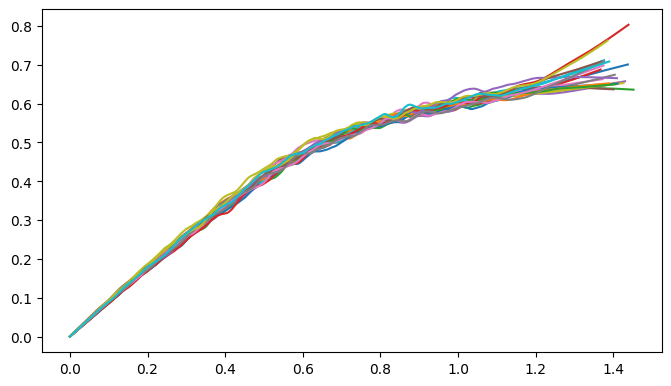

In [21]:
n_imgs = 128 #512

fig = plt.figure(figsize=(8,8), dpi=100)
for k in tqdm(range(20)):
    # generate center
    latent_center = torch.randn((n_imgs, nz, 1, 1), device=device)

    # generate image
    img_center = netG(latent_center)

    # jitter the latent center with noise and generate image
    dxs = []
    dis = []
    for p in np.linspace(0, 1, 200):
        # generate noise
        noise = torch.randn(n_imgs, nz, 1, 1, device=device)
        
        # jitter
        img_jitter =  netG((1-p)*latent_center + p * noise)
        
        # distances
        dx = (latent_center - (1-p)*latent_center - p*noise).abs().mean((1,2,3)).detach().cpu()
        di = (img_center - img_jitter).abs().mean((1,2,3)).detach().cpu()
        
        # cleanup
        del(noise)
        del(img_jitter)
        
        # save data
        dxs.extend(dx)
        dis.extend(di)
    
    # cleanup
    del(img_center)

    # add smooth fit
    lowess = sm.nonparametric.lowess(dis, dxs, frac=0.05)
    
    # plot
    plt.plot(lowess[:, 0], lowess[:, 1])

plt.gca().set_aspect("equal")
plt.show()

# Traverse between two points in latent space

In [ ]:
n_imgs = 64

# generate center
latent_center = torch.randn((n_imgs, nz, 1, 1), device=device)

# generate image
img_center = netG(latent_center).detach().cpu()

In [ ]:
# generate noise vector
noise = torch.randn(n_imgs, nz, 1, 1, device=device)

# interpolate between the latent center and noise and generate image
imgs_jitter = []
for p in np.linspace(0, 1, 50):
    imgs_jitter.append(netG((1-p)*latent_center + p * noise).detach().cpu())

imgs_jitter = [vutils.make_grid(i, nrow = math.ceil(math.sqrt(n_imgs)), padding=2, normalize=True) for i in imgs_jitter]
    
# prepare animation
fig = plt.figure(figsize=(math.ceil(math.sqrt(n_imgs)), math.ceil(math.sqrt(n_imgs))), dpi=48)
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in imgs_jitter]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

# display animation
HTML(ani.to_jshtml())